### 1. Read in the enriched PartB data for year 2013 & 2014

In [1]:
import pandas as pd
import numpy as np
import sklearn
import random
import cloudpickle
import os 
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

parent = os.path.dirname(os.getcwd())
df = pd.read_csv(parent + '/Capstone_project/data/year2013_2014_combined_with_labels.csv')
df.fillna(0, inplace=True)

print(sum(df.Fraud_Indicator ==1))

df['Rndrng_Prvdr_Type'] = df['Rndrng_Prvdr_Type'].astype('category').cat.codes
df['Rndrng_Prvdr_Gndr'] = df['Rndrng_Prvdr_Gndr'].astype('category').cat.codes
df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'] = df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'].astype('category').cat.codes

# df_2015 = df[df.YEAR== 2015]
# df = df[df.YEAR.isin([2013, 2014])]
print(df.shape)

2550
(1847558, 89)


### 2. Split the data to a train set (used for cross validation) and a test set (holdout)

In [3]:
# split out the holdout data by Rndrng_NPI to avoid data leakage
random.seed(42)
holdout_rate = 0.1

uniq_id = df.Rndrng_NPI.unique()
holdout_set = random.sample(list(uniq_id), int(len(uniq_id)*holdout_rate))
train_set = list(set(uniq_id) - set(holdout_set))

train=df.query("`Rndrng_NPI` in @train_set")
holdout=df.query("`Rndrng_NPI` in @holdout_set")

train_X = train.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
train_y = train.Fraud_Indicator

test_X = holdout.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
test_y = holdout.Fraud_Indicator

print(train_X.shape, test_X.shape)

(1662708, 86) (184850, 86)


### 3. Build up a pipeline including evaluation

In [3]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# define pipeline
def RF_roc_auc_eval(undersample_rate= None, weight = 'balanced'):
    
    rf = RandomForestClassifier(class_weight= weight, random_state=42, n_jobs=-1)
    
    if undersample_rate == None:
        steps = [('scaler', StandardScaler()),
                 ('rf', rf)]
        
    elif undersample_rate != None:
        under = RandomUnderSampler(sampling_strategy=undersample_rate, random_state =42)
        steps = [('under', under), 
                 ('scaler', StandardScaler()),
                 ('rf', rf)] 
        
    pipeline = Pipeline(steps=steps)

    skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

    param_grid = {'rf__n_estimators':[100],
                  'rf__min_samples_leaf': [2, 5, 8],
                  'rf__min_samples_split': [2, 5, 8],
                  'rf__bootstrap': [False],
                  'rf__max_depth': [50, 100, 200, 500],
                  'rf__max_features': ['sqrt'],
                  'rf__max_leaf_nodes': [5, 10, 50, 100]
                  }
    
    grid_pipe = GridSearchCV(estimator = pipeline, 
                             param_grid = param_grid, 
                             scoring= 'roc_auc', 
                             n_jobs =-1,
                             cv = skf,
                             verbose = 1)
    
    grid_result = grid_pipe.fit(train_X, train_y)
    print('Best Score: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)
    

    scores = cross_val_score(grid_result.best_estimator_, train_X, train_y, scoring = 'roc_auc', cv=skf, n_jobs=-1)
    print('Mean ROC AUC: %.3f' % np.mean(scores), 
          'SD ROC AUC: %.4f' % np.std(scores))
    
    val_auc = roc_auc_score(test_y, grid_result.best_estimator_.predict_proba(test_X)[:, 1])
    print('Test set ROC AUC  %.3f' % val_auc)
    return round(np.mean(scores), 4), round(np.std(scores), 5), round(val_auc, 4), grid_result.best_estimator_

def plot_confusion_matrix(estimator, test_X, test_y):
    # Create the NumPy array for actual and predicted labels.
    actual    = test_y
    predicted = estimator.predict(test_X)

    # compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)

    # Plot the confusion matrix.
    sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=['Non-Fraud','Fraud'],
                yticklabels=['Non-Fraud','Fraud'])
    plt.ylabel('Actual',fontsize=15)
    plt.xlabel('Prediction',fontsize=15)
    plt.title('Confusion Matrix', fontsize=17)
    return plt.show()

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Score:  0.839409948186942
Best Params:  {'rf__bootstrap': False, 'rf__max_depth': 50, 'rf__max_features': 'sqrt', 'rf__max_leaf_nodes': 100, 'rf__min_samples_leaf': 8, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Mean ROC AUC: 0.839 SD ROC AUC: 0.0020
Test set ROC AUC  0.817
(0.8394, 0.00205, 0.8165)


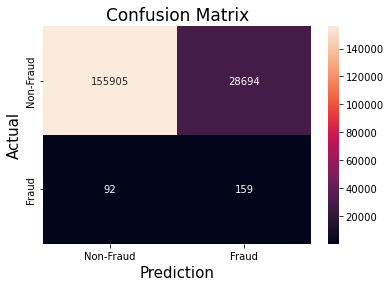

In [4]:
# undersample the majority/minority labels to ratio 10:1
rf_1 = RF_roc_auc_eval(0.1)
print(rf_1[:3])
rf_pipe1 = rf_1[3]
plot_confusion_matrix(rf_pipe1, test_X, test_y)

cloudpickle.dump(rf_pipe1, open('rf_pipe1.cloudpickle','wb'))

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Score:  0.8374281335845928
Best Params:  {'rf__bootstrap': False, 'rf__max_depth': 50, 'rf__max_features': 'sqrt', 'rf__max_leaf_nodes': 100, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Mean ROC AUC: 0.837 SD ROC AUC: 0.0019
Test set ROC AUC  0.817
(0.8374, 0.00195, 0.8166)


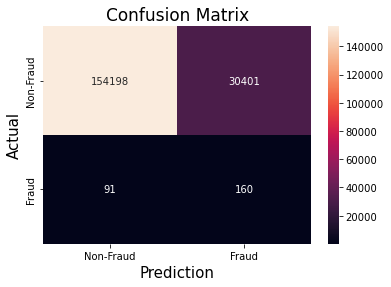

In [5]:
# undersample the majority/minority labels to ratio 4:1 (80:20)
rf_2 = RF_roc_auc_eval(0.25)
print(rf_2[:3])
rf_pipe2 = rf_2[3]
plot_confusion_matrix(rf_pipe2, test_X, test_y)

cloudpickle.dump(rf_pipe2, open('rf_pipe2.cloudpickle','wb'))

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Score:  0.8332794466819607
Best Params:  {'rf__bootstrap': False, 'rf__max_depth': 50, 'rf__max_features': 'sqrt', 'rf__max_leaf_nodes': 100, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 100}
Mean ROC AUC: 0.833 SD ROC AUC: 0.0013
Test set ROC AUC  0.819
(0.8333, 0.00131, 0.8192)


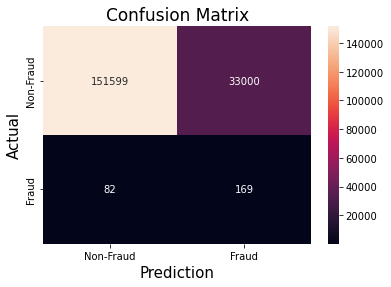

In [6]:
# undersample the majority/minority labels to ratio 2:1
rf_3 = RF_roc_auc_eval(0.5)
print(rf_3[:3])
rf_pipe3 = rf_3[3]
plot_confusion_matrix(rf_pipe3, test_X, test_y)

cloudpickle.dump(rf_pipe3, open('rf_pipe3.cloudpickle','wb'))

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Score:  0.8284539926280686
Best Params:  {'rf__bootstrap': False, 'rf__max_depth': 50, 'rf__max_features': 'sqrt', 'rf__max_leaf_nodes': 100, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Mean ROC AUC: 0.828 SD ROC AUC: 0.0037
Test set ROC AUC  0.819
(0.8285, 0.00367, 0.8186)


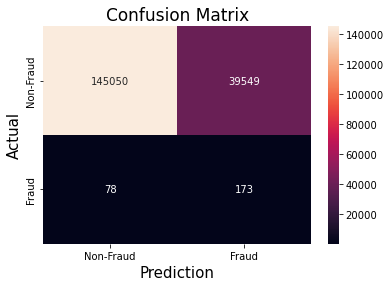

In [7]:
# undersample the majority/minority labels to ratio 1:1
rf_4 = RF_roc_auc_eval(1)
print(rf_4[:3])
rf_pipe4 = rf_4[3]
plot_confusion_matrix(rf_pipe4, test_X, test_y)

cloudpickle.dump(rf_pipe4, open('rf_pipe4.cloudpickle','wb'))